# EDA -- ECLI Citation

In [ ]:
#!pip install langdetect
#!pip install -U sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.8/150.8 MB 24.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 23.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from langdetect import detect
import pandas as pd
import ast 
import re
from collections import Counter
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer, util

In [9]:
data_dir = Path("/Users/xuewang/Desktop/UvA/dsp/data")

## 1. Data Preparation

### 1.1 Data Loading

In [10]:
df_letters = pd.read_excel("Dataset Advice letters on objections towing of bicycles.xlsx",
                        engine="openpyxl")

df_letters.info()
df_letters.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 567 entries, 0 to 566
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Octopus zaaknummer          567 non-null    object
 1   Zaaktype                    567 non-null    object
 2   Onderwerp                   567 non-null    object
 3   Dictum                      567 non-null    object
 4   geanonimiseerd_doc_inhoud   567 non-null    object
 5   unieke_woorden_stopwoorden  567 non-null    object
 6   ECLI                        567 non-null    object
dtypes: object(7)
memory usage: 31.1+ KB


,Octopus zaaknummer,Zaaktype,Onderwerp,Dictum,geanonimiseerd_doc_inhoud,unieke_woorden_stopwoorden,ECLI
0,JB.19.012268.001,Bezwaar,AWB - Fietsbezwaren (AWB),Deels (on)gegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,"['ECLI:NL:GHDHA:2014:2134', 'ECLI:NL:RBAMS:201..."
1,JB.21.010531.001,Bezwaar,AWB - Fietsbezwaren (AWB),Deels (on)gegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,['ECLI:NL:GHDHA:2014:2134']
2,JB.21.010880.001,Bezwaar,AWB - Fietsbezwaren (AWB),Ongegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,['ECLI:NL:GHDHA:2014:2134']
3,JB.21.010883.001,Bezwaar,AWB - Fietsbezwaren (AWB),Ongegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,['ECLI:NL:GHDHA:2014:2134']
4,JB.21.013099.001,Bezwaar,AWB - Fietsbezwaren (AWB),Gegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,['ECLI:NL:GHDHA:2014:2134']


In [11]:
df_ecli = pd.read_excel("DATA ecli_nummers juni 2025 v1 (version 1).xlsx",
                        engine="openpyxl")

df_ecli.info()
df_ecli.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2447 entries, 0 to 2446
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ecli_nummer  2447 non-null   object
 1   land         2447 non-null   object
 2   rechtbank    2447 non-null   object
 3   jaar         2447 non-null   int64 
 4   code         2447 non-null   object
 5   ecli_tekst   2447 non-null   object
 6   lengte       2447 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 133.9+ KB


,ecli_nummer,land,rechtbank,jaar,code,ecli_tekst,lengte
0,ECLI:NL:HR:2014:39,NL,HR,2014,39,\nRvdW 2014/158\n\n\n\n\nhttp://deeplink.recht...,1614
1,ECLI:NL:HR:2020:848,NL,HR,2020,848,\nRvdW 2020/657\n\n\n\n\nhttp://deeplink.recht...,1969
2,ECLI:NL:RVS:2020:64,NL,RVS,2020,64,\n\n\n\n\nhttp://deeplink.rechtspraak.nl/uitsp...,2197
3,ECLI:NL:RVS:2023:3417,NL,RVS,2023,3417,\n\n\n\n\nhttp://deeplink.rechtspraak.nl/uitsp...,2247
4,ECLI:NL:RVS:2019:1964,NL,RVS,2019,1964,\n\n\n\n\nhttp://deeplink.rechtspraak.nl/uitsp...,2326


### 1.2. Missing Values? No

In [12]:
print("Letters:", df_letters.shape)
print("ECLI cases:", df_ecli.shape)

print("Missing in letters:")
print(df_letters.isna().sum())

print("Missing in ECLI cases:")
print(df_ecli.isna().sum())

Letters: (567, 7)
ECLI cases: (2447, 7)
Missing in letters:
Octopus zaaknummer            0
Zaaktype                      0
Onderwerp                     0
Dictum                        0
geanonimiseerd_doc_inhoud     0
unieke_woorden_stopwoorden    0
ECLI                          0
dtype: int64
Missing in ECLI cases:
ecli_nummer    0
land           0
rechtbank      0
jaar           0
code           0
ecli_tekst     0
lengte         0
dtype: int64


In [13]:
letters_ecli = df_letters["ECLI"].dropna().unique()
cases_ecli = df_ecli["ecli_nummer"].dropna().unique()

missing_ecli = [e for e in letters_ecli if e not in cases_ecli]
print(f"{len(missing_ecli)} cited ECLIs not found in the ECLI dataset.")

47 cited ECLIs not found in the ECLI dataset.


### 1.3. Explode the letter dataset (89 (out of 567) letters cited more than 1 ECLI)


In [14]:
df_letters["ECLI"] = df_letters["ECLI"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith("[") else [x]
)

# Ensure it's always a list (for single ECLIs)
df_letters["ECLI"] = df_letters["ECLI"].apply(
    lambda x: x if isinstance(x, list) else [str(x)]
)

# Explode into multiple rows
letters_exploded = df_letters.explode("ECLI").reset_index(drop=True)

# Clean whitespace and remove empty entries
letters_exploded["ECLI"] = letters_exploded["ECLI"].str.strip()
letters_exploded = letters_exploded[letters_exploded["ECLI"].str.len() > 0]

letters_exploded.head()


,Octopus zaaknummer,Zaaktype,Onderwerp,Dictum,geanonimiseerd_doc_inhoud,unieke_woorden_stopwoorden,ECLI
0,JB.19.012268.001,Bezwaar,AWB - Fietsbezwaren (AWB),Deels (on)gegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,ECLI:NL:GHDHA:2014:2134
1,JB.19.012268.001,Bezwaar,AWB - Fietsbezwaren (AWB),Deels (on)gegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,ECLI:NL:RBAMS:2018:6527
2,JB.21.010531.001,Bezwaar,AWB - Fietsbezwaren (AWB),Deels (on)gegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,ECLI:NL:GHDHA:2014:2134
3,JB.21.010880.001,Bezwaar,AWB - Fietsbezwaren (AWB),Ongegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,ECLI:NL:GHDHA:2014:2134
4,JB.21.010883.001,Bezwaar,AWB - Fietsbezwaren (AWB),Ongegrond,Advies van de bezwaarschriftencommissie Juridi...,advies van de bezwaarschriftencommissie juridi...,ECLI:NL:GHDHA:2014:2134


In [15]:
# If ECLI_citation is a list already
df_letters["ECLI_count_before"] = df_letters["ECLI"].apply(lambda x: len(x) if isinstance(x, list) else 1)

# Summary
df_letters["ECLI_count_before"].describe()
df_letters["ECLI_count_before"].value_counts().head()

ECLI_count_before
1    478
2     76
3      9
8      2
4      2
Name: count, dtype: int64

In [16]:
letters_exploded = df_letters.explode("ECLI").reset_index(drop=True)

# Compare shape before vs after
print(f"Before exploding: {df_letters.shape[0]} rows")
print(f"After exploding:  {letters_exploded.shape[0]} rows")

# How many rows now per original letter ID
letters_exploded_counts = letters_exploded.groupby("Octopus zaaknummer")["ECLI"].count()
letters_exploded_counts.describe()


Before exploding: 567 rows
After exploding:  681 rows


count    567.000000
mean       1.201058
std        0.601939
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        8.000000
Name: ECLI, dtype: float64

In [17]:
letters_ecli = letters_exploded["ECLI"].dropna().unique()
cases_ecli = df_ecli["ecli_nummer"].dropna().unique()

missing_ecli = [e for e in letters_ecli if e not in cases_ecli]
print(f"{len(missing_ecli)} cited ECLIs not found in the ECLI dataset.")

6 cited ECLIs not found in the ECLI dataset.


### Note: not all of the cited ECLIs can be found in the ECLI dataset. 6 not found

### 1.5. Language Check: all Dutch

In [20]:
letters_exploded["lang"] = letters_exploded["geanonimiseerd_doc_inhoud"].dropna().apply(lambda x: detect(x[:200]) if isinstance(x, str) else None)
letters_exploded["lang"].value_counts()

lang
nl    681
Name: count, dtype: int64

### 1.6. 
#### 1.6.1 Letters: Zaaktype: 1 type, Bezwaar. Onderwerp: 1 typ,e AWB - Fietsbezwaren. Dictum: 5 types.

In [ ]:
print(letters_exploded["Zaaktype"].value_counts().head(20))
print(letters_exploded["Onderwerp"].value_counts().head(20))
print(letters_exploded["Dictum"].value_counts().head(20))

Zaaktype
Bezwaar    681
Name: count, dtype: int64
Onderwerp
AWB - Fietsbezwaren (AWB)    681
Name: count, dtype: int64
Dictum
Ongegrond                    499
Niet-ontvankelijk            133
Gegrond                       31
Deels (on)gegrond             15
Gegrond - terugverwijzing      3
Name: count, dtype: int64


#### 1.6.2 ECLI: land: 1 type, NL. rechtbank: more than 20.

In [ ]:
print(df_ecli["land"].value_counts().head(20))
print(df_ecli["rechtbank"].value_counts().head(20))
print(df_ecli["jaar"].value_counts().head(20))

land
NL    2447
Name: count, dtype: int64
rechtbank
RVS      1859
RBAMS     193
CRVB       86
HR         42
CBB        41
RBMNE      33
GHARL      20
RBDHA      20
RBROT      18
GHAMS      17
RBNHO      17
RBGEL      14
RBOVE      11
RBLIM      10
RBOBR       9
GHDHA       8
RvS         6
RBZWB       6
GHSHE       5
RBNNE       5
Name: count, dtype: int64
jaar
2018    316
2019    289
2020    219
2017    207
2016    189
2021    173
2022    156
2015    131
2014    126
2013    105
2023    100
2012     85
2024     62
2011     50
2010     42
2009     39
2008     33
2007     24
2006     22
2005     21
Name: count, dtype: int64


### 1.7. Data Cleanning

#### 1.7.1. standardize column names and formats

In [23]:
letters_exploded["ECLI"] = letters_exploded["ECLI"].astype(str).str.strip().str.upper()
df_ecli["ecli_nummer"] = df_ecli["ecli_nummer"].astype(str).str.strip().str.upper()

#### 1.7.2. check matching coverage

In [64]:
matches = letters_exploded["ECLI"].isin(df_ecli["ecli_nummer"])
print(f"Match rate: {matches.mean():.2%} of ECLIs in letters found in df_ecli")

missing = letters_exploded.loc[~matches, "ECLI"].unique()
print("Missing ECLI examples:", missing[:10])

Match rate: 98.38% of ECLIs in letters found in df_ecli
Missing ECLI examples: ['ECLI:NL:GHDHA:2017:2134' 'ECLI:NL:RBAMS:2018:751'
 'ECLI:NL:RBANR:2002:AF2030' 'ECLI:NL:RBDHA:2016:1216'
 'ECLI:NL:RBDHA:2016:2168' 'ECLI:NL:RVS:2019:052']


#### 1.7.3. clean and prepare text columns

In [ ]:
def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^A-Za-zÀ-ÿ0-9.,;:?!()€%\'"–\- ]', '', text)
    return text.strip()

letters_exploded["geanonimiseerd_doc_inhoud"] = letters_exploded["geanonimiseerd_doc_inhoud"].apply(clean_text)
df_ecli["ecli_tekst"] = df_ecli["ecli_tekst"].apply(clean_text)

In [ ]:
queries1 = letters_exploded["geanonimiseerd_doc_inhoud"].tolist()
queries2 = letters_exploded["unieke_woorden_stopwoorden"].tolist()
documents = df_ecli["ecli_tekst"].tolist()

#### 1.7.4. save the dataset

In [ ]:
letters_exploded.to_csv("clean_letters_exploded.csv", index=False)
df_ecli.to_csv("clean_df_ecli.csv", index=False)

## 2. EDA

In [ ]:
print("Letters:", letters_exploded.shape)
print("ECLI cases:", df_ecli.shape)
print("Unique ECLIs cited:", letters_exploded['ECLI'].nunique())
print("Total ECLIs in case data:", df_ecli['ecli_nummer'].nunique())

Letters: (681, 11)
ECLI cases: (2447, 8)
Unique ECLIs cited: 31
Total ECLIs in case data: 2442


### 2.1 Text length & distribution
Helps to decide chunking parameters later for embedding.

In [ ]:
letters_exploded["n_words"] = letters_exploded["geanonimiseerd_doc_inhoud"].astype(str).str.split().str.len()
letters_exploded["n_stopwoorden"] = letters_exploded["unieke_woorden_stopwoorden"].astype(str).str.split().str.len()
df_ecli["n_words"] = df_ecli["ecli_tekst"].astype(str).str.split().str.len()

print(letters_exploded["n_words"].describe())
print(letters_exploded["n_stopwoorden"].describe())
print(df_ecli["n_words"].describe())

#letters: geanonimiseerd_doc_inhoud	unieke_woorden_stopwoorden
#ecli: ecli_tekst

count     681.000000
mean     1426.170338
std       644.256809
min       319.000000
25%      1083.000000
50%      1376.000000
75%      1755.000000
max      3674.000000
Name: n_words, dtype: float64
count    681.000000
mean     412.493392
std      127.152596
min      162.000000
25%      358.000000
50%      410.000000
75%      474.000000
max      765.000000
Name: n_stopwoorden, dtype: float64
count    2447.000000
mean     2485.347773
std      1269.200435
min       226.000000
25%      1495.500000
50%      2172.000000
75%      3252.500000
max      5315.000000
Name: n_words, dtype: float64


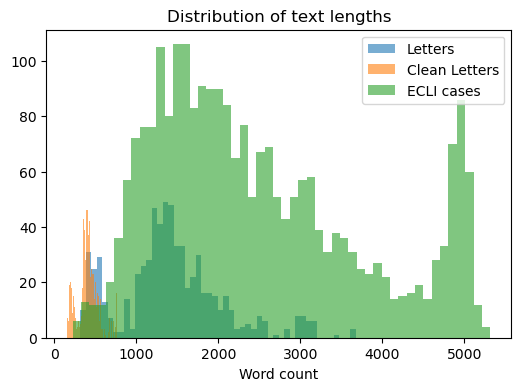

In [53]:
plt.figure(figsize=(6,4))
plt.hist(letters_exploded['n_words'], bins=50, alpha=0.6, label='Letters')
plt.hist(letters_exploded['n_stopwoorden'], bins=50, alpha=0.6, label='Clean Letters')
plt.hist(df_ecli['n_words'], bins=50, alpha=0.6, label='ECLI cases')
plt.legend()
plt.xlabel('Word count')
plt.title('Distribution of text lengths')
plt.show()

### 2.2. Citation Patterns
Frequent ECLIs can be used as evaluation benchmarks later.

ECLI
ECLI:NL:RBDHA:2016:12168    211
ECLI:NL:RBAMS:2018:7511     162
ECLI:NL:RVS:2014:2398       154
ECLI:NL:RBAMS:2017:1136      48
ECLI:NL:GHDHA:2014:2134      35
ECLI:NL:RBAMS:2015:1603      13
ECLI:NL:RVS:2019:4152        13
ECLI:NL:RBAMS:2018:6527       7
ECLI:NL:RBDHA:2016:1216       6
ECLI:NL:RVS:2010:BM4174       3
Name: count, dtype: int64


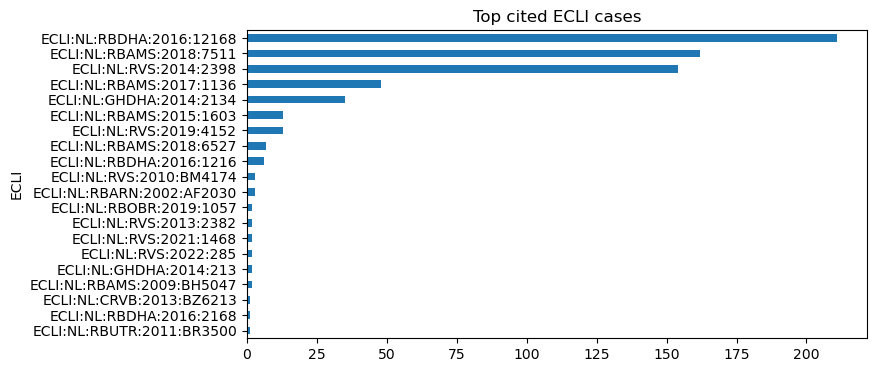

In [ ]:
letters_per_case = letters_exploded['ECLI'].value_counts()
print(letters_per_case.head(10))

plt.figure(figsize=(8,4))
letters_per_case.head(20).plot(kind='barh', title='Top cited ECLI cases')
plt.gca().invert_yaxis()
plt.show()

<Axes: title={'center': 'Number of ECLIs per letter'}, xlabel='ECLI'>

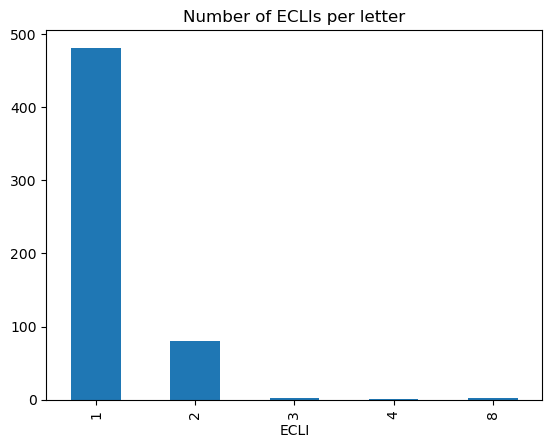

In [ ]:
citation_counts = letters_exploded.groupby('Octopus zaaknummer')['ECLI'].nunique()
citation_counts.value_counts().sort_index().plot(kind='bar', title='Number of ECLIs per letter')

### 2.3. Match-level exploration
Identifies which courts produce the most cited decisions (e.g., RBDHA for The Hague) and whether citations are mostly recent or old.

In [ ]:
merged = letters_exploded.merge(
    df_ecli,
    left_on='ECLI',
    right_on='ecli_nummer',
    how='left'
)

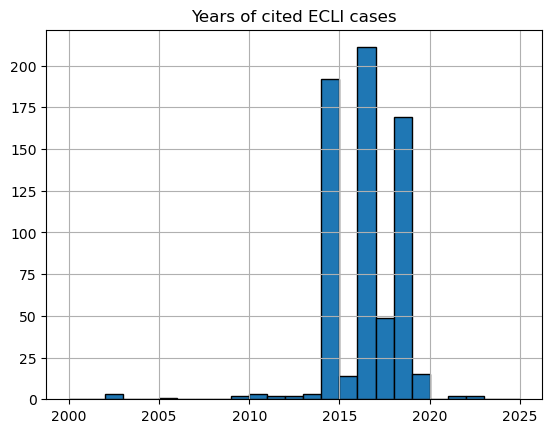

In [ ]:
merged['rechtbank'].value_counts().head(10)
merged['jaar'] = pd.to_numeric(merged['jaar'], errors='coerce')
merged['jaar'].hist(bins=range(2000, 2026), edgecolor='black')
plt.title('Years of cited ECLI cases')
plt.show()

### 2.4. Lexical / semantic overlap (letters vs. cases) -- The whole datasets.
Low overlap → lexical gap between municipal letters and court judgments
High overlap → good news; embedding retrieval will align easily.

In [ ]:
# nltk.download('stopwords')
stop_dutch = stopwords.words("dutch")
vectorizer = CountVectorizer(stop_words=stop_dutch, max_features=1000)

# Fit on each dataset and get vocabulary
vocab_letters = set(vectorizer.fit(letters_exploded['geanonimiseerd_doc_inhoud']).get_feature_names_out())
vocab_cases = set(vectorizer.fit(df_ecli['ecli_tekst']).get_feature_names_out())

# Compute lexical overlap
overlap = len(vocab_letters & vocab_cases) / len(vocab_letters | vocab_cases)
print(f"Vocabulary overlap between letters and ECLI texts: {overlap:.2%}")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wangxue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Vocabulary overlap between letters and ECLI texts: 31.84%


### 2.5. Lexical / semantic overlap (vocabulary overlap per letter vs. its cited ECLIs).

In [ ]:
def get_vocab(text):
    if not isinstance(text, str):
        return set()
    tokens = re.findall(r"\b\w+\b", text.lower())
    return set([t for t in tokens if t not in stop_dutch and len(t) > 2])


In [56]:
merged["vocab_letter"] = merged["geanonimiseerd_doc_inhoud"].apply(get_vocab)
merged["vocab_case"] = merged["ecli_tekst"].apply(get_vocab)

merged["overlap_ratio"] = merged.apply(
    lambda row: len(row["vocab_letter"] & row["vocab_case"]) /
                len(row["vocab_letter"] | row["vocab_case"])
                if row["vocab_letter"] and row["vocab_case"] else 0,
    axis=1
)


In [ ]:
print("Average overlap:", merged["overlap_ratio"].mean())
print("Median overlap:", merged["overlap_ratio"].median())

merged[["Octopus zaaknummer", "ECLI", "overlap_ratio"]].head()

Average overlap: 0.16357257464759337
Median overlap: 0.15734265734265734


,Octopus zaaknummer,ECLI,overlap_ratio
0,JB.19.012268.001,ECLI:NL:GHDHA:2014:2134,0.123217
1,JB.19.012268.001,ECLI:NL:RBAMS:2018:6527,0.213710
2,JB.21.010531.001,ECLI:NL:GHDHA:2014:2134,0.116317
3,JB.21.010880.001,ECLI:NL:GHDHA:2014:2134,0.106534
4,JB.21.010883.001,ECLI:NL:GHDHA:2014:2134,0.106534


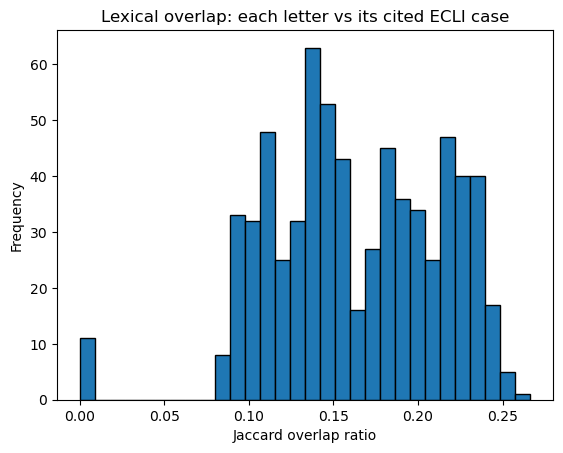

In [59]:
plt.hist(merged["overlap_ratio"], bins=30, edgecolor='black')
plt.title("Lexical overlap: each letter vs its cited ECLI case")
plt.xlabel("Jaccard overlap ratio")
plt.ylabel("Frequency")
plt.show()


In [61]:
random_cases = df_ecli.sample(len(merged), random_state=42)["ecli_tekst"].tolist()
merged["random_case_vocab"] = [get_vocab(t) for t in random_cases]

merged["overlap_random"] = merged.apply(
    lambda row: len(row["vocab_letter"] & row["random_case_vocab"]) /
                len(row["vocab_letter"] | row["random_case_vocab"])
                if row["vocab_letter"] and row["random_case_vocab"] else 0,
    axis=1
)

print("True pairs mean overlap:", merged["overlap_ratio"].mean())
print("Random pairs mean overlap:", merged["overlap_random"].mean())


True pairs mean overlap: 0.16357257464759337
Random pairs mean overlap: 0.11360334207044405


### 2.6. Word frequency analysis (domain characterization)
Expect to see terms like “fiets”, “weg”, “verordening”, “gemeente”, confirming domain focus.

In [ ]:
def tokenize(text):
    return [w.lower() for w in re.findall(r"\b\w+\b", text) if w.lower() not in stop_dutch]

all_words = []
letters_exploded['geanonimiseerd_doc_inhoud'].apply(lambda x: all_words.extend(tokenize(x)))
Counter(all_words).most_common(20)


[('fiets', 19779),
 ('naam', 13974),
 ('bezwaarde', 8039),
 ('fietsen', 7094),
 ('gebied', 5862),
 ('bezwaarschrift', 5180),
 ('uur', 5149),
 ('commissie', 4769),
 ('buiten', 4480),
 ('besluit', 4445),
 ('geparkeerd', 3952),
 ('overtreding', 3938),
 ('verwijderd', 3746),
 ('artikel', 3671),
 ('geeft', 3455),
 ('4', 3423),
 ('amsterdam', 3388),
 ('sticker', 3388),
 ('5', 3323),
 ('aangewezen', 3264)]

### 2.7. Dictum (decision) patterns
You can later test whether RAG retrieval varies by case outcome type.

In [ ]:
letters_exploded['Dictum'].value_counts()
letters_exploded.groupby(['Dictum','ECLI']).size().unstack(fill_value=0).head()

ECLI,ECLI:NL:CRVB:2013:BZ6213,ECLI:NL:GHDHA:2014:213,ECLI:NL:GHDHA:2014:2134,ECLI:NL:GHDHA:2017:2134,ECLI:NL:HR:2011:BT7470,ECLI:NL:HR:2012:BY0531,ECLI:NL:RBAMS:2009:BH5047,ECLI:NL:RBAMS:2015:1603,ECLI:NL:RBAMS:2017:1136,ECLI:NL:RBAMS:2018:6527,...,ECLI:NL:RVS:2012:BY2474,ECLI:NL:RVS:2013:2382,ECLI:NL:RVS:2014:239,ECLI:NL:RVS:2014:2398,ECLI:NL:RVS:2015:302,ECLI:NL:RVS:2017:476,ECLI:NL:RVS:2019:052,ECLI:NL:RVS:2019:4152,ECLI:NL:RVS:2021:1468,ECLI:NL:RVS:2022:285
Dictum,,,,,,,,,,,,,,,,,,,,,
Deels (on)gegrond,0,0,4,0,0,0,0,1,1,1,...,0,0,0,4,0,0,0,1,0,0
Gegrond,1,0,12,1,0,1,0,0,0,3,...,1,0,0,2,0,0,0,0,0,0
Gegrond - terugverwijzing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Niet-ontvankelijk,0,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,1,8,0,0
Ongegrond,0,1,19,0,0,0,2,12,47,3,...,0,2,1,147,1,0,0,4,2,2


### 2.8. sentence-level vs. keyword-based comparison (queries1 vs. queries2)
Shows how much compression your “unique words” representation achieves — helpful if you plan lightweight matching later.

In [ ]:
lens1 = [len(q.split()) for q in queries1]
lens2 = [len(q.split()) for q in queries2]
print(np.mean(lens1), np.mean(lens2))

1426.1703377386198 412.49339207048456


### 2.9. Semantic similarity sampling
If the correct ECLI is retrieved (or ranks high), your text preprocessing is working well.

In [69]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_dutch = stopwords.words("dutch")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/wangxue/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# 1) TF-IDF over the ECLI corpus (documents)
tfidf = TfidfVectorizer(stop_words=stop_dutch, max_df=0.9, min_df=3)
X_docs = tfidf.fit_transform(df_ecli["ecli_tekst"])  # shape: [num_cases, |V|]

# 2) Prepare queries (letters)
Q_texts = letters_exploded["geanonimiseerd_doc_inhoud"].tolist()
Q_ecli_true = letters_exploded["ECLI"].tolist()           # ground truth ECLI per query

# 3) Transform all queries at once
Q = tfidf.transform(Q_texts)  # shape: [num_queries, |V|]

# 4) Compute cosine sim in manageable batches to avoid high RAM (adjust batch size if needed)
def batched_topk(Q, X_docs, k=10, batch=64):
    topk_idx = []
    for i in range(0, Q.shape[0], batch):
        sims = cosine_similarity(Q[i:i+batch], X_docs)      # [b, num_docs]
        idx = np.argsort(-sims, axis=1)[:, :k]              # top-k indices
        topk_idx.append(idx)
    return np.vstack(topk_idx)

topk = batched_topk(Q, X_docs, k=10, batch=64)              # ndarray [num_queries, 10]
topk_ecli = df_ecli["ecli_nummer"].to_numpy()[topk]         # map to ECLI codes


In [ ]:
def recall_at_k(topk_ecli, truth, k=1):
    hits = [(truth[i] in set(topk_ecli[i, :k])) for i in range(len(truth))]
    return float(np.mean(hits))

def mrr_at_k(topk_ecli, truth, k=10):
    rr = []
    for i in range(len(truth)):
        ranks = np.where(topk_ecli[i, :k] == truth[i])[0]
        rr.append(1.0/(ranks[0]+1) if len(ranks)>0 else 0.0)
    return float(np.mean(rr))

print("TF-IDF Recall@1:", recall_at_k(topk_ecli, Q_ecli_true, k=1))
print("TF-IDF Recall@5:", recall_at_k(topk_ecli, Q_ecli_true, k=5))
print("TF-IDF Recall@10:", recall_at_k(topk_ecli, Q_ecli_true, k=10))
print("TF-IDF MRR@10:",   mrr_at_k(topk_ecli, Q_ecli_true, k=10))

TF-IDF Recall@1: 0.22173274596182085
TF-IDF Recall@5: 0.44640234948604995
TF-IDF Recall@10: 0.5389133627019089
TF-IDF MRR@10: 0.31560904831829945


In [74]:
! pip install rank_bm25
from rank_bm25 import BM25Okapi

def tokenize(s):
    return re.findall(r"\b\w+\b", s.lower())

docs_tokens = [tokenize(t) for t in df_ecli["ecli_tekst"].astype(str)]
bm25 = BM25Okapi(docs_tokens)

def bm25_topk(query, k=10):
    qtok = tokenize(query)
    scores = bm25.get_scores(qtok)
    idx = np.argsort(-scores)[:k]
    return idx

# Evaluate BM25
topk_idx_bm25 = np.vstack([bm25_topk(q, k=10) for q in Q_texts])
topk_ecli_bm25 = df_ecli["ecli_nummer"].to_numpy()[topk_idx_bm25]

print("BM25 Recall@1:", recall_at_k(topk_ecli_bm25, Q_ecli_true, k=1))
print("BM25 Recall@5:", recall_at_k(topk_ecli_bm25, Q_ecli_true, k=5))
print("BM25 Recall@10:", recall_at_k(topk_ecli_bm25, Q_ecli_true, k=10))
print("BM25 MRR@10:",   mrr_at_k(topk_ecli_bm25, Q_ecli_true, k=10))

BM25 Recall@1: 0.21145374449339208
BM25 Recall@5: 0.5095447870778267
BM25 Recall@10: 0.5301027900146843
BM25 MRR@10: 0.32851956739621935
